In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the data from the CSV file
df = pd.read_csv('cleaned_adw_df_1.csv')
cols_to_remove = ['Delay National Aviation System (Minutes)_a', 'Delay Security (Minutes)_a', 'Delay Late Aircraft Arrival (Minutes)_a', 
                  'Delay National Aviation System (Minutes)_d', 'Delay Security (Minutes)_d', 'Delay Late Aircraft Arrival (Minutes)_d']
df = df.drop(columns=cols_to_remove)

# filtered data based on year
years_to_filter = {2019,2020,2021,2022,2023}
df = df[df['Year'].isin(years_to_filter)]

airport = 'MCO'

df = df[df['Origin Airport_a']==airport]

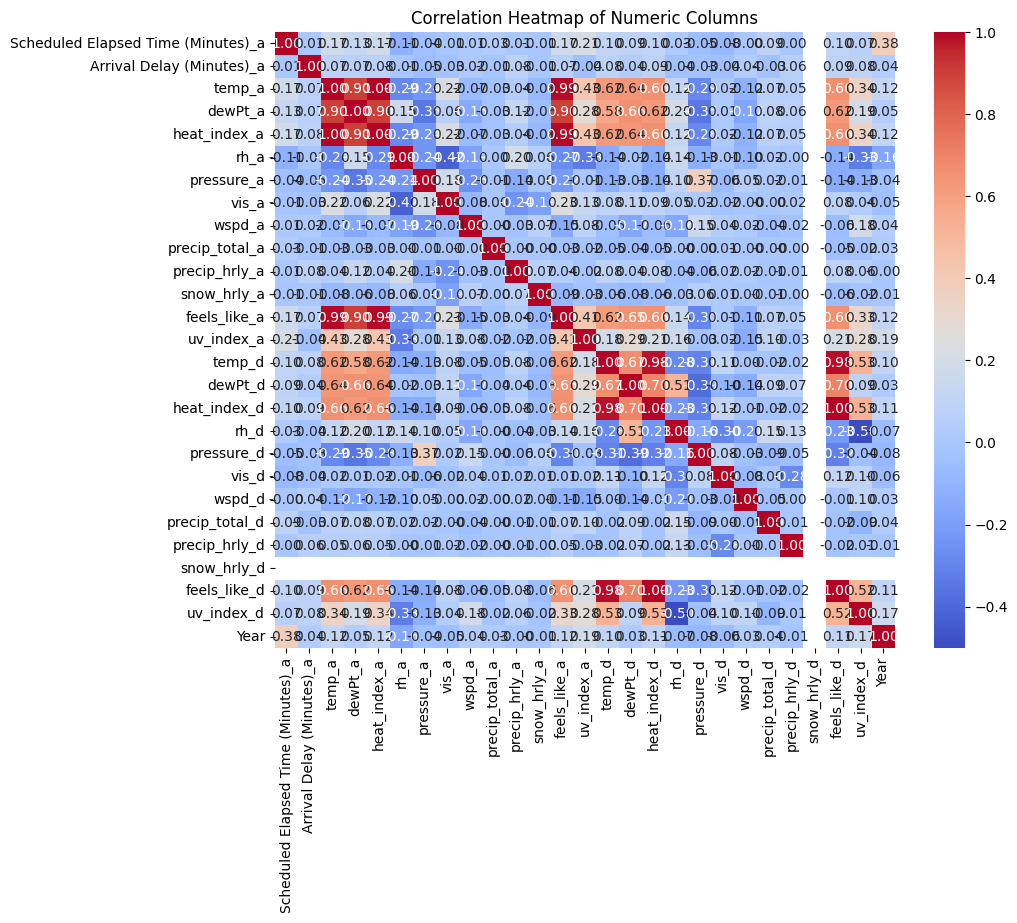

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# corr_matrix = df.corr(numeric_only=True)
# sns.heatmap(corr_matrix, cmap='coolwarm')

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

In [11]:
# Convert categorical variables to numerical using one-hot encoding
categorical_cols = ['Origin Airport_a', 'wx_phrase_a', 'uv_desc_a', 'clds_a',
                    'wx_phrase_d', 'uv_desc_d', 'clds_d', 'Main_Carrier', 'Week_Category', 'A_Time_of_Day']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Calculate correlation with "Arrival Delay (Minutes)_a" and sort by absolute value
corr_with_delay = df.corr()['Arrival Delay (Minutes)_a'].abs().sort_values(ascending=False)

# print(corr_with_delay)

# Select top 12 features with low intercorrelation
selected_features = []
for feature in corr_with_delay.index:
    if len(selected_features) >= 25:
        break
    if corr_with_delay[feature] >= -0.1:
        selected_features.append(feature)
        
selected_features.remove('Arrival Delay (Minutes)_a')
print(selected_features)

# Print remaining numerical columns
remaining_numeric_cols = [col for col in numeric_cols.columns if col not in selected_features]
remaining_numeric_cols.remove('Arrival Delay (Minutes)_a')
print("Remaining Numerical Columns:")
print(remaining_numeric_cols)

# Remove the specified columns

columns_to_remove = remaining_numeric_cols
# .append('Year')

df = df.drop(columns=remaining_numeric_cols)

['A_Time_of_Day_Evening', 'wx_phrase_d_Stormy', 'A_Time_of_Day_Morning Peak', 'heat_index_d', 'feels_like_d', 'uv_desc_d_Low', 'temp_d', 'uv_index_d', 'precip_hrly_a', 'heat_index_a', 'temp_a', 'dewPt_a', 'uv_desc_d_Moderate', 'feels_like_a', 'wx_phrase_d_Rainy', 'Main_Carrier_WN', 'precip_hrly_d', 'clds_d_FEW', 'pressure_a', 'clds_d_OVC', 'dewPt_d', 'uv_index_a', 'vis_d', 'rh_d']
Remaining Numerical Columns:
['Scheduled Elapsed Time (Minutes)_a', 'rh_a', 'vis_a', 'wspd_a', 'precip_total_a', 'snow_hrly_a', 'pressure_d', 'wspd_d', 'precip_total_d', 'snow_hrly_d', 'Year']


In [12]:
df.head(2)

Arrival Delay (Minutes)_a  temp_a  dewPt_a  heat_index_a  pressure_a  \
5                       -23.0    33.0     30.0          33.0       29.62   
12                       18.0    24.0     17.0          24.0       29.76   

    precip_hrly_a  feels_like_a  uv_index_a  temp_d  dewPt_d  ...  clds_d_OVC  \
5             0.0          24.0         0.0    78.0     65.0  ...       False   
12            0.0          15.0         0.0    73.0     67.0  ...       False   

    clds_d_SCT  Main_Carrier_WN  Week_Category_StartOfWeek  \
5         True            False                      False   
12       False            False                      False   

    Week_Category_Weekend  A_Time_of_Day_Evening  A_Time_of_Day_Evening Peak  \
5                   False                  False                       False   
12                  False                  False                       False   

    A_Time_of_Day_Morning  A_Time_of_Day_Morning Peak  A_Time_of_Day_Night  
5                   False                       False                False  
12                  False                       False                 True  

[2 rows x 47 columns]

In [13]:
def calculate_summary_statistics(df, columns):
    # Separate numerical and categorical columns based on the input list
    numerical_cols = [col for col in columns if df[col].dtype in ['int64', 'float64']]
    categorical_cols = [col for col in columns if df[col].dtype in ['object', 'category']]
    boolean_cols = [col for col in columns if df[col].dtype == 'bool']

    # Calculate average for numerical columns
    numerical_avg = df[numerical_cols].mean()

    # # Calculate mode for categorical columns
    # categorical_mode = df[categorical_cols].mode().iloc[0]

    # Print the summary statistics
    print("Average for Numerical Columns:")
    print(numerical_avg)
    # print("\nMode for Categorical Columns:")
    # print(categorical_mode)
        # Calculate proportion of True values for boolean columns
    for col in boolean_cols:
        true_prop = df[col].mean()  # True proportion is the mean (since True=1, False=0)
    print(f"\nProportion of True values in column '{col}': {true_prop:.2%}")

calculate_summary_statistics(df, selected_features)

Average for Numerical Columns:
heat_index_d     78.404137
feels_like_d     78.362763
temp_d           76.451053
uv_index_d        2.067603
precip_hrly_a     0.004281
heat_index_a     51.374215
temp_a           51.213521
dewPt_a          37.836350
feels_like_a     48.254525
precip_hrly_d     0.005501
pressure_a       29.558460
dewPt_d          62.705948
uv_index_a        0.828223
vis_d             9.752401
rh_d             64.824898
dtype: float64

Proportion of True values in column 'clds_d_OVC': 12.86%


In [14]:
# Define the target variable based on arrival delay
df['Class of Arrival Time'] = pd.cut(df['Arrival Delay (Minutes)_a'],
                                       bins=[float('-inf'), -5, 5, float('inf')],
                                       labels=['Early', 'On-time', 'Late'])

# Drop unnecessary columns and the target variable
X = df.drop(['Arrival Delay (Minutes)_a', 'Class of Arrival Time'], axis=1)
y = df['Class of Arrival Time']
# y = df['Arrival Delay (Minutes)_a']

X_encoded = X
# Standardize numerical columns
numerical_cols = selected_features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y,stratify = y,test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Identify the model with the highest accuracy
best_model_name = None
best_accuracy = 0

# Initialize and train different models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42,n_estimators = 250,max_depth = 50, learning_rate= 1 ),
    'ada' : AdaBoostClassifier(random_state=42),
# 'xg':  XGBClassifier(random_state=42),
'knn' : KNeighborsClassifier(n_neighbors=15),
'dtree':  DecisionTreeClassifier(max_depth=7,random_state=42),
'rand_class':  RandomForestClassifier(max_depth=15,random_state=42),
'GNB':  GaussianNB()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
    # mae = mean_absolute_error(y_test, y_pred)
    # mae_ratio = mae / np.mean(y_test)
    # print("MAE:", mae)
    # print("MAE Ratio:", mae_ratio)
    # print(model.score(X_test,y_test))
    # print(classification_report(y_test, y_pred))
    # print('-' * 50)

# Select the best model
best_model = models[best_model_name]

print("model with most accuracy is " + str(best_model))

Logistic Regression Accuracy: 0.47
Decision Tree Accuracy: 0.39


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest Accuracy: 0.50
SVM Accuracy: 0.50
Gradient Boosting Accuracy: 0.44
ada Accuracy: 0.46
knn Accuracy: 0.48
dtree Accuracy: 0.45
rand_class Accuracy: 0.50
GNB Accuracy: 0.22
model with most accuracy is SVC(random_state=42)


In [17]:

# Load the data from the CSV file
df = pd.read_csv('CIS_662_FINAL_Predictions.csv')

# Filter rows with ORIGIN as airport
airport_data_index = df[df['Origin Airport_a'] == airport].index

# Perform one-hot encoding on the specfic aiport data using previous encoder
airport_data_encoded = pd.get_dummies(df.loc[airport_data_index], columns=categorical_cols, drop_first=True)

# Standardize numerical columns using previous scaler
airport_data_encoded[numerical_cols] = scaler.transform(airport_data_encoded[numerical_cols])

# Drop any columns not used in the training data
airport_data_encoded = airport_data_encoded[X_train.columns]

# Make predictions using the selected model
predictions = best_model.predict(airport_data_encoded)

# Create a new column 'y' in the specific airport data subset and store the predictions in it
df.loc[airport_data_index, 'ARRIVAL TIME'] = predictions

# Save the updated DataFrame back to the same file
df.to_csv('CIS_662_FINAL_Predictions.csv', index=False)

print(airport + " airport prediction for ARRIVAL STATUS are created")


MCO airport prediction for ARRIVAL STATUS are created
